# Analysis and Baseline

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import joblib

from math import ceil
from gensim.models import Word2Vec
from nltk import FreqDist
from collections import defaultdict
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [2]:
train = pd.read_csv('data/train_data_restaurant.tsv', names = ['text' , 'target'], delimiter='\t', header=None)
test = pd.read_csv('data/test_data_restaurant.tsv', names = ['text' , 'target'], delimiter='\t', header=None)

## 1. Analysis

First, let's look inside our data

### 1.1. Class Distribution

Text(0, 0.5, 'samples')

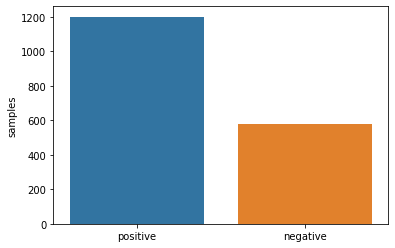

In [3]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

### 1.2. Number of  character in a text

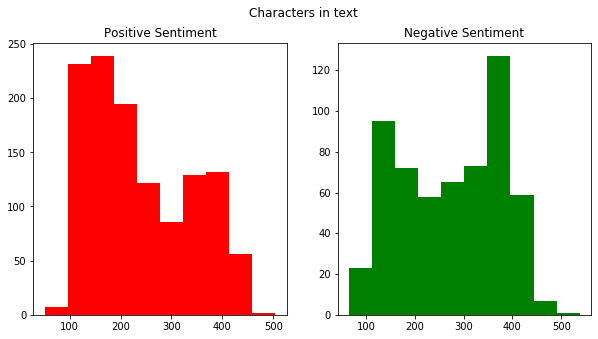

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
text_len = train[train['target']=='positive']['text'].str.len()
ax1.hist(text_len, color='red')
ax1.set_title('Positive Sentiment')

text_len = train[train['target']=='negative']['text'].str.len()
ax2.hist(text_len, color='green')
ax2.set_title('Negative Sentiment')

fig.suptitle('Characters in text')
plt.show()

### 1.3. Number of Words in a Text

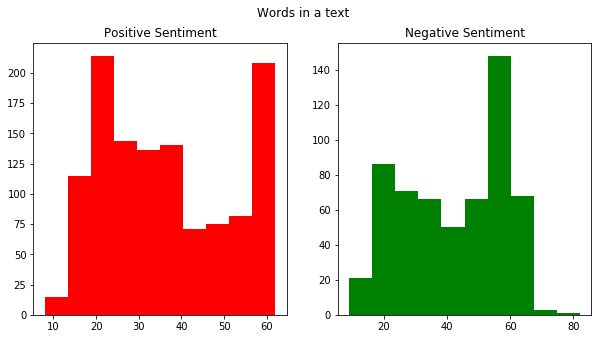

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
num_words = train[train['target']=='positive']['text'].str.split().map(lambda x: len(x))
ax1.hist(num_words, color='red')
ax1.set_title('Positive Sentiment')

num_words = train[train['target']=='negative']['text'].str.split().map(lambda x: len(x))
ax2.hist(num_words, color='green')
ax2.set_title('Negative Sentiment')

fig.suptitle('Words in a text')
plt.show()

### 1.4. Average word length in a text

Text(0.5, 0.98, 'Average word length in each text')

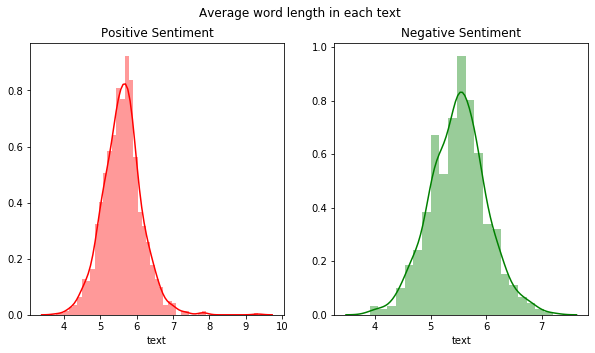

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
word = train[train['target']=='positive']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Positive Sentiment')

word = train[train['target']=='negative']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Negative Sentiment')

fig.suptitle('Average word length in each text')

### 1.5. Common words in a text

In [7]:
text_positive = train[train['target']=='positive']['text'].str.split()
text_negative = train[train['target']=='negative']['text'].str.split()

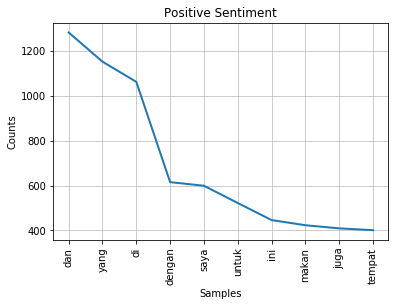

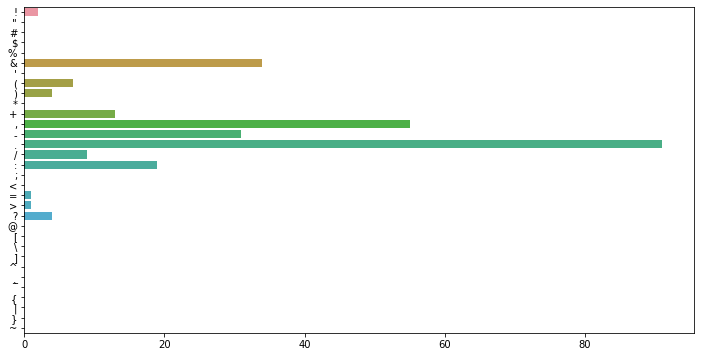

In [8]:
fdist = FreqDist(word.lower() for sentence in text_positive for word in sentence)
fdist.plot(10, title="Positive Sentiment")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

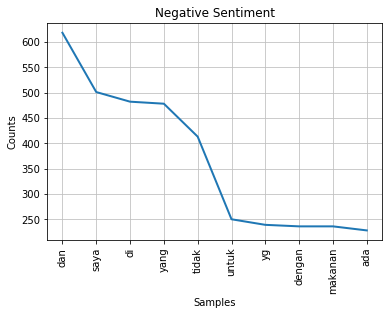

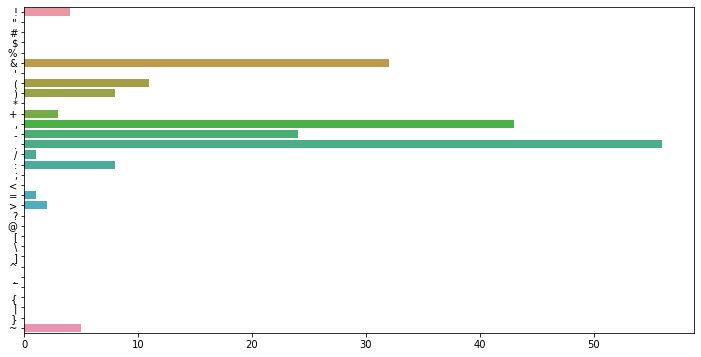

In [9]:
fdist = FreqDist(word.lower() for sentence in text_negative for word in sentence)
fdist.plot(10, title="Negative Sentiment")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

### 1.6. Bi-gram analysis

In [10]:
def get_top_text_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

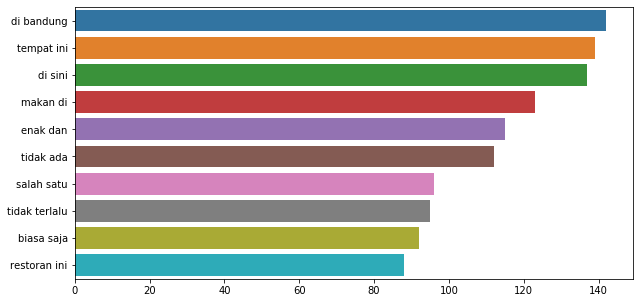

In [11]:
plt.figure(figsize=(10,5))
top_text_bigram = get_top_text_bigram(train['text'].tolist())[:10]
x,y = map(list, zip(*top_text_bigram))
sns.barplot(y,x)

## 2. Baseline

In [12]:
X_train = train['text'].tolist()
X_test = test['text'].tolist()

y_train = np.array([1 if i == 'positive' else 0 for i in train.target.values])
y_test = np.array([1 if i == 'positive' else 0 for i in test.target.values])

In [13]:
def fit_and_predict(vec, clf, filename):
    pipe = make_pipeline(vec, clf)
    pipe.fit(X_train, y_train)
    acc = pipe.score(X_test, y_test)
    print("Accuracy: ", acc)
    model = joblib.dump(pipe, filename+".sav")

### 2.1 Liniear Regression

#### 2.1.1 Using countvectorizer

In [14]:
vec = CountVectorizer(lowercase=True)
clf = LogisticRegression()
fit_and_predict(vec, clf, filename='LR Countvectorizer')

Accuracy:  0.8864864864864865


#### 2.1.2 Using TF-IDF

In [15]:
vec = TfidfVectorizer(lowercase=True)
clf = LogisticRegression()
fit_and_predict(vec, clf, filename='LR TF-IDF')

Accuracy:  0.827027027027027


#### 2.1.3 Using countvectorizer bigram

In [16]:
vec = CountVectorizer(ngram_range=(1,2), lowercase=True)
clf = LogisticRegression()
fit_and_predict(vec, clf, filename='LR Countvectorizer Bi-gram')

Accuracy:  0.8756756756756757


### 2.2 Support Vector Machine

In [17]:
vec = CountVectorizer(lowercase=True)
clf = svm.SVC()
fit_and_predict(vec, clf, filename='Support Vector Machine')

Accuracy:  0.8648648648648649


### 2.3 LSTM

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten

Using TensorFlow backend.


In [19]:
def tokenize_reshape(data):
    data = tok.texts_to_matrix(data)
    return np.reshape(data, (data.shape[0], 1, data.shape[1]))

In [20]:
tok = Tokenizer(num_words=1000)
tok.fit_on_texts(X_train)

In [21]:
x_train = tokenize_reshape(X_train)
x_test = tokenize_reshape(X_test)

In [22]:
print(x_train.shape)
print(x_test.shape)

(1780, 1, 1000)
(185, 1, 1000)


#### 2.3.1 1-Layer LSTM

In [23]:
model = Sequential()
model.add(LSTM(200, input_shape=(1, x_train.shape[2]), return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

W0312 12:31:45.325281 13968 deprecation_wrapper.py:119] From C:\Users\LENOVO\Anaconda3\envs\fhadli\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0312 12:31:45.354204 13968 deprecation_wrapper.py:119] From C:\Users\LENOVO\Anaconda3\envs\fhadli\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0312 12:31:45.362219 13968 deprecation_wrapper.py:119] From C:\Users\LENOVO\Anaconda3\envs\fhadli\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0312 12:31:45.678374 13968 deprecation_wrapper.py:119] From C:\Users\LENOVO\Anaconda3\envs\fhadli\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0312 12:31:45.702274 13968 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 200)            960800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 961,001
Trainable params: 961,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(x_train, y_train, epochs=10)
score = model.evaluate(x_test, y_test, batch_size=128)
print(f"The accuary is: {score[1]}")

W0312 12:31:46.410412 13968 deprecation_wrapper.py:119] From C:\Users\LENOVO\Anaconda3\envs\fhadli\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.5329 - acc: 0.7438
Epoch 2/10
1780/1780 [==============================] - 1s 682us/step - loss: 0.2929 - acc: 0.8893
Epoch 3/10
1780/1780 [==============================] - 1s 703us/step - loss: 0.1901 - acc: 0.9242
Epoch 4/10
1780/1780 [==============================] - 1s 703us/step - loss: 0.1311 - acc: 0.9539
Epoch 5/10
1780/1780 [==============================] - 1s 716us/step - loss: 0.0887 - acc: 0.9747
Epoch 6/10
1780/1780 [==============================] - 1s 702us/step - loss: 0.0606 - acc: 0.9848
Epoch 7/10
1780/1780 [==============================] - 1s 709us/step - loss: 0.0414 - acc: 0.9927
Epoch 8/10
1780/1780 [==============================] - 1s 696us/step - loss: 0.0279 - acc: 0.9966
Epoch 9/10
1780/1780 [==============================] - 1s 704us/step - loss: 0.0194 - acc: 0.9978
Epoch 10/10
185/185 [==============================] - 0s 1ms/step
The accuary is: 0.8216216145335017


In [25]:
model.save("1-Layer LSTM.h5")
model.save_weights('1-Layer LSTM_weights.h5')

#### 2.3.2 2-Layer Bi-LSTM

In [26]:
model = Sequential()
model.add(LSTM(200, input_shape=(1, x_train.shape[2]), return_sequences=True))
model.add(LSTM(200, return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 200)            960800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 200)            320800    
_________________________________________________________________
flatten_2 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 1,281,801
Trainable params: 1,281,801
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(x_train, y_train, epochs=10)
score = model.evaluate(x_test, y_test, batch_size=128)
print(f"The accuary is: {score[1]}")

Epoch 1/10
1780/1780 [==============================] - 3s 2ms/step - loss: 0.5147 - acc: 0.7478
Epoch 2/10
1780/1780 [==============================] - 2s 848us/step - loss: 0.2467 - acc: 0.8978
Epoch 3/10
1780/1780 [==============================] - 2s 854us/step - loss: 0.1319 - acc: 0.9461
Epoch 4/10
1780/1780 [==============================] - 2s 850us/step - loss: 0.0681 - acc: 0.9775
Epoch 5/10
1780/1780 [==============================] - 2s 891us/step - loss: 0.0389 - acc: 0.9893
Epoch 6/10
1780/1780 [==============================] - 2s 961us/step - loss: 0.0432 - acc: 0.9860
Epoch 7/10
1780/1780 [==============================] - 2s 876us/step - loss: 0.0381 - acc: 0.9865
Epoch 8/10
1780/1780 [==============================] - 2s 883us/step - loss: 0.0170 - acc: 0.9938
Epoch 9/10
1780/1780 [==============================] - 2s 944us/step - loss: 0.0212 - acc: 0.9938
Epoch 10/10
185/185 [==============================] - 0s 2ms/step
The accuary is: 0.827027022194218


In [28]:
model.save("2-Layer Bi-LSTM.h5")
model.save_weights('2-Layer Bi-LSTM_weights.h5')

#### 2.3.2 2-Layer Bi-LSTM with Word2Vec

In [29]:
model = Word2Vec.load("Word2Vec/id.bin")

In [30]:
def tokenize(data):
    tokenized=[]
    for d in data:
        tokenized.append(nltk.word_tokenize(d.lower()))
    return tokenized

In [31]:
def vectorize(tokenized_data):
    vectorized=[]
    for sentence in tokenized_data:
        sentvec = [model.wv[w] for w in sentence if w in model.wv.vocab]
        vectorized.append(sentvec)
    return vectorized

In [32]:
def padding(encoded_docs):
    padded_posts = []

    for post in encoded_docs:
        # Pad short posts with alternating min/max
        if len(post) < max_sentence_length:

            # Method 1
            pointwise_min = np.minimum.reduce(post)
            pointwise_max = np.maximum.reduce(post)
            padding = [pointwise_max, pointwise_min]

            # Method 2
            #pointwise_avg = np.mean(post)
            #padding = [pointwise_avg]

            post += padding * ceil((max_sentence_length - len(post) / 2.0))

        # Shorten long posts or those odd number length posts we padded to 51
        if len(post) > max_sentence_length:
            post = post[:max_sentence_length]

        # Add the post to our new list of padded posts
        padded_posts.append(post)
    return padded_posts

In [33]:
tok_train = tokenize(X_train)
tok_test = tokenize(X_test)

In [34]:
vec_train = vectorize(tok_train)
vec_test = vectorize(tok_test)

In [35]:
length=[len(vec) for vec in vec_train]
max_sentence_length = np.int(np.mean(length))

In [36]:
pad_train = padding(vec_train)
pad_test = padding(vec_test)

In [37]:
X_train = np.array(pad_train)
X_test = np.array(pad_test)

In [38]:
print(X_train.shape)
print(X_test.shape)

(1780, 36, 300)
(185, 36, 300)


In [39]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(200, return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 36, 200)           400800    
_________________________________________________________________
lstm_5 (LSTM)                (None, 36, 200)           320800    
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7201      
Total params: 728,801
Trainable params: 728,801
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train, y_train, epochs=10)
score = model.evaluate(X_test, y_test)
print(f"The accuary is: {score[1]}")

Epoch 1/10
1780/1780 [==============================] - 7s 4ms/step - loss: 0.5199 - acc: 0.7444A: 1s - loss: 0.5074 - a
Epoch 2/10
1780/1780 [==============================] - 5s 3ms/step - loss: 0.3748 - acc: 0.8376A: 0s - loss: 0.3777 - acc: 0.
Epoch 3/10
1780/1780 [==============================] - 5s 3ms/step - loss: 0.2806 - acc: 0.8809
Epoch 4/10
1780/1780 [==============================] - 5s 3ms/step - loss: 0.1804 - acc: 0.9292
Epoch 5/10
1780/1780 [==============================] - 6s 3ms/step - loss: 0.0946 - acc: 0.9624
Epoch 6/10
1780/1780 [==============================] - 6s 3ms/step - loss: 0.0637 - acc: 0.9764
Epoch 7/10
1780/1780 [==============================] - 6s 3ms/step - loss: 0.0328 - acc: 0.9888
Epoch 8/10
1780/1780 [==============================] - 6s 3ms/step - loss: 0.0269 - acc: 0.9893
Epoch 9/10
1780/1780 [==============================] - 6s 3ms/step - loss: 0.0243 - acc: 0.9921
Epoch 10/10
185/185 [==============================] - 1s 4ms/step
The ac

In [41]:
model.save("2-Layer Bi-LSTM Word2Vec.h5")
model.save_weights('2-Layer Bi-LSTM Word2Vec_weights.h5')